<a href="https://colab.research.google.com/github/matheusro/Uniritter-topicos2-NLP/blob/master/Trabalho_Topicos_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático - Processamento de Linguagem Natural
Disciplina: Tópicos II / Professor: William Becker

### Alunos:
Gustavo da Costa Oliveira / Vinícius Valim de Melo / Cláudia Duarte Rodrigues de Oliveira / Matheus Reck de Oliveira

Fonte do Dataset: https://www.kaggle.com/cursostic/avaliao-atendimento#all.csv

Os dados analisados contêm **avaliações de atendimento de equipe de Suporte de TI**.

Neste trabalho iremos realizar uma Análise de Sentimentos (elogio ou reclamação) sobre o nível de atendimento da área frente aos usuários da empresa.

In [1]:
import warnings
import numpy as np
import pandas as pd
import nltk
import unicodedata
import re
import matplotlib.pyplot as plt 

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\i815354\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\i815354\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\i815354\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


In [4]:
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
from sklearn import svm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [5]:
dataset = pd.read_excel("all.xlsx")

In [6]:
print(dataset)

                                                  coment manifest_atendimento
0                              Nunca abri esse incidente               neutro
1      Profissionais educados, atenciosos e o mais im...               elogio
2      Não tenho condições de responder a esta pesqui...           reclamação
3      Chamado não foi resolvido. Apesar de explicado...           reclamação
4      O chamado foi encerrado como concluído. Porém,...           reclamação
5          Houve uma demora para a solução do problema.            reclamação
6      Demora relativamente alta para resolução em um...           reclamação
7      Foi informado que o skype não poderia ser inst...               neutro
8        Aguardando parecer do gerente da minha unidade.               neutro
9      Em princípio foi resolvido. Só terei certeza n...               neutro
10     Excelente o atendimento do técnico Ricardo Nog...               elogio
11     Concluíram o chamado sem verificar se o proble...        

Ao descrever o dataset abaixo, percebe-se que existem algumas avaliações de atendimento onde os usuários não fizeram nenhum comentário **(8 casos)**.

Coincidentemente, alguns usuários incluiram exatamente os mesmos comentários na avaliação. No entanto, ainda temos muitos comentários exclusivos, **totalizando 31253**.

O comentário mais reincidente foi o elogio de **"Excelente atendimento."**, sendo apresentado **634 vezes**.

In [7]:
# guarda os comentários puros em um novo campo para realizar um comparativo dos modelos no final
dataset['coment_puro'] = dataset['coment']

Como primeiro ajuste do dataset, removemos os registros que não tiveram nenhum comentário.

In [8]:
dataset = dataset[dataset["coment"].isnull() == False]

In [9]:
print(dataset.describe()) 

                        coment manifest_atendimento             coment_puro
count                    42306                42306                   42306
unique                   31253                    3                   31253
top     Excelente atendimento.               elogio  Excelente atendimento.
freq                       634                27630                     634


Analisando as classes originais do dataset, temos a seguinte distribuição:

In [10]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
neutro         8174
reclamação     6502
Name: manifest_atendimento, dtype: int64


Para simplificar o modelo, vamos trabalhar somente com duas categorias (elogio e reclamação). Neste caso, iremos considerar que todas avaliações neutras também são reclamação.

In [11]:
dataset.loc[dataset.manifest_atendimento == 'neutro', 'manifest_atendimento'] = 'reclamação'

In [12]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
reclamação    14676
Name: manifest_atendimento, dtype: int64


Abaixo, nós convertemos os tipos de dado dos campos 'coment' para 'str' e 'manifest_atendimento' para 'category'.

In [13]:
dataset['coment'] = dataset.coment.astype(str)
dataset['coment_puro'] = dataset.coment.astype(str)
dataset['manifest_atendimento'] = dataset.manifest_atendimento.astype('category')

A seguir, iniciamos alguns tratamentos específicos do campo 'coment', como por exemplo a tokenização e a limpeza de caracteres especiais.

In [14]:
def removerAcentosECaracteresEspeciais(palavra):

    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)

In [15]:
def pre_processamento(text):
    replace_espaco = re.compile('[/(){}\[\]\|@,;]')
    text = text.lower()
    text = replace_espaco.sub(' ', text)
    return text



In [16]:
dataset['coment'] = dataset['coment'].apply(pre_processamento)
dataset['coment'] = dataset['coment'].apply(removerAcentosECaracteresEspeciais)
print(dataset)

                                                  coment manifest_atendimento  \
0                              nunca abri esse incidente           reclamação   
1      profissionais educados  atenciosos e o mais im...               elogio   
2      nao tenho condicoes de responder a esta pesqui...           reclamação   
3      chamado nao foi resolvido apesar de explicado ...           reclamação   
4      o chamado foi encerrado como concluido porem  ...           reclamação   
5           houve uma demora para a solucao do problema            reclamação   
6      demora relativamente alta para resolucao em um...           reclamação   
7      foi informado que o skype nao poderia ser inst...           reclamação   
8         aguardando parecer do gerente da minha unidade           reclamação   
9      em principio foi resolvido so terei certeza no...           reclamação   
10     excelente o atendimento do tecnico ricardo nog...               elogio   
11     concluiram o chamado 

**Tokenização** de cada um dos comentários:

In [17]:
dataset["coment"] = [word_tokenize(word) for word in dataset["coment"]]
print(dataset)

                                                  coment manifest_atendimento  \
0                         [nunca, abri, esse, incidente]           reclamação   
1      [profissionais, educados, atenciosos, e, o, ma...               elogio   
2      [nao, tenho, condicoes, de, responder, a, esta...           reclamação   
3      [chamado, nao, foi, resolvido, apesar, de, exp...           reclamação   
4      [o, chamado, foi, encerrado, como, concluido, ...           reclamação   
5      [houve, uma, demora, para, a, solucao, do, pro...           reclamação   
6      [demora, relativamente, alta, para, resolucao,...           reclamação   
7      [foi, informado, que, o, skype, nao, poderia, ...           reclamação   
8      [aguardando, parecer, do, gerente, da, minha, ...           reclamação   
9      [em, principio, foi, resolvido, so, terei, cer...           reclamação   
10     [excelente, o, atendimento, do, tecnico, ricar...               elogio   
11     [concluiram, o, chama

Aplicamos em seguida a remoção de **stopwords** da língua portuguesa e **stemming** sobre as palavras para obtenção dos radicais, guardando-as no campo **'coment_stem'**:

In [18]:
dataset["coment_stopwords"] = dataset["coment"].apply(lambda x: [item for item in x if item not in stopwords.words("portuguese")])
print(dataset)

                                                  coment manifest_atendimento  \
0                         [nunca, abri, esse, incidente]           reclamação   
1      [profissionais, educados, atenciosos, e, o, ma...               elogio   
2      [nao, tenho, condicoes, de, responder, a, esta...           reclamação   
3      [chamado, nao, foi, resolvido, apesar, de, exp...           reclamação   
4      [o, chamado, foi, encerrado, como, concluido, ...           reclamação   
5      [houve, uma, demora, para, a, solucao, do, pro...           reclamação   
6      [demora, relativamente, alta, para, resolucao,...           reclamação   
7      [foi, informado, que, o, skype, nao, poderia, ...           reclamação   
8      [aguardando, parecer, do, gerente, da, minha, ...           reclamação   
9      [em, principio, foi, resolvido, so, terei, cer...           reclamação   
10     [excelente, o, atendimento, do, tecnico, ricar...               elogio   
11     [concluiram, o, chama

In [19]:
def Stemming(sentence):
    stemmer = RSLPStemmer()
    phrase = []
    for word in sentence:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

In [20]:
dataset['coment_stem'] = dataset['coment_stopwords'].apply(Stemming)
print(dataset)

                                                  coment manifest_atendimento  \
0                         [nunca, abri, esse, incidente]           reclamação   
1      [profissionais, educados, atenciosos, e, o, ma...               elogio   
2      [nao, tenho, condicoes, de, responder, a, esta...           reclamação   
3      [chamado, nao, foi, resolvido, apesar, de, exp...           reclamação   
4      [o, chamado, foi, encerrado, como, concluido, ...           reclamação   
5      [houve, uma, demora, para, a, solucao, do, pro...           reclamação   
6      [demora, relativamente, alta, para, resolucao,...           reclamação   
7      [foi, informado, que, o, skype, nao, poderia, ...           reclamação   
8      [aguardando, parecer, do, gerente, da, minha, ...           reclamação   
9      [em, principio, foi, resolvido, so, terei, cer...           reclamação   
10     [excelente, o, atendimento, do, tecnico, ricar...               elogio   
11     [concluiram, o, chama

A seguir é apresentado um ranking das palavras mais frequentes nos comentários, onde percebemos que a mais mencionada foi o radical **'atend'**, sendo exibida mais de **25000 vezes**.

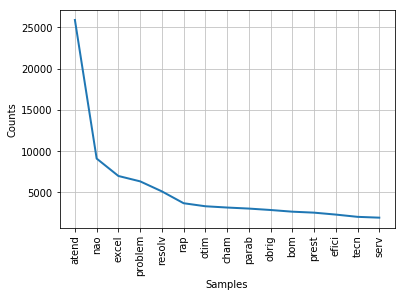

In [21]:
fdist = FreqDist()
for word in dataset['coment_stem']:
    for token in word:      
        fdist[token] += 1
fdist.plot(15)

Para entender melhor a distribuição das palavras frequentes, geramos 4 visões de nuvem de palavras, sendo as duas primeiras dos 'elogios' (stopwords e stemming) e as seguintes das 'reclamações' (stopwords e stemming).

In [22]:
dataset["coment"] = [' '.join(word) for word in dataset["coment"]]
dataset["coment_stopwords"] = [' '.join(word) for word in dataset["coment_stopwords"]]
dataset["coment_stem"] = [' '.join(word) for word in dataset["coment_stem"]]
print(dataset)

                                                  coment manifest_atendimento  \
0                              nunca abri esse incidente           reclamação   
1      profissionais educados atenciosos e o mais imp...               elogio   
2      nao tenho condicoes de responder a esta pesqui...           reclamação   
3      chamado nao foi resolvido apesar de explicado ...           reclamação   
4      o chamado foi encerrado como concluido porem o...           reclamação   
5            houve uma demora para a solucao do problema           reclamação   
6      demora relativamente alta para resolucao em um...           reclamação   
7      foi informado que o skype nao poderia ser inst...           reclamação   
8         aguardando parecer do gerente da minha unidade           reclamação   
9      em principio foi resolvido so terei certeza no...           reclamação   
10     excelente o atendimento do tecnico ricardo nog...               elogio   
11     concluiram o chamado 

In [23]:
def nuvem_palavras(dataset):

    comment_words = ''  
    stopwords = set(STOPWORDS)

    for i in range(0, len(dataset)):
        val = dataset.iloc[i]['coment']
        tokens = val.split() 
      
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
              
        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
      
    plt.show() 

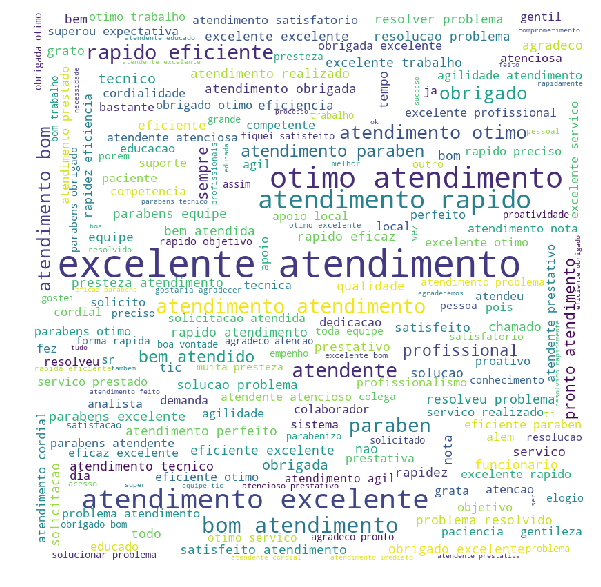

In [24]:
elogios = dataset[dataset['manifest_atendimento']=='elogio']
elogios.coment = elogios.coment_stopwords
nuvem_palavras(elogios)

Na visão acima, temos como destaque as palavras **excelente**, **otimo** e **atendimento**.

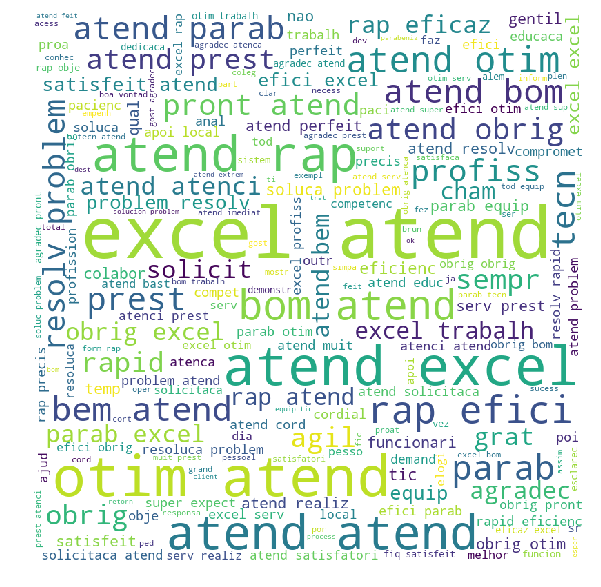

In [25]:
elogios.coment = elogios.coment_stem
nuvem_palavras(elogios)

Com os radicais, percebemos que as palavras **excel** e **atend** potencializam na suas frequencia, pois podemos ter muitas variações de escrita, como 'atendimento', 'atender', 'atendido', etc.

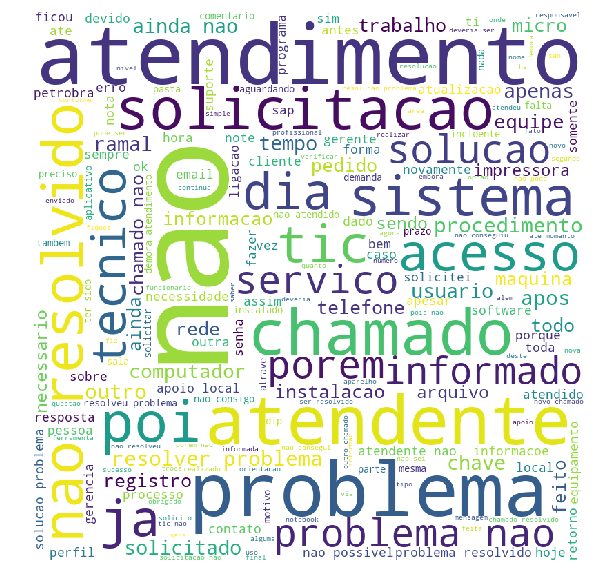

In [26]:
reclamacoes = dataset[dataset['manifest_atendimento']=='reclamação']
reclamacoes.coment = reclamacoes.coment_stopwords
nuvem_palavras(reclamacoes)

Nas reclamações, é bem comum o cenário acima, onde temos o **nao** em destaque, além obviamente do **problema**.

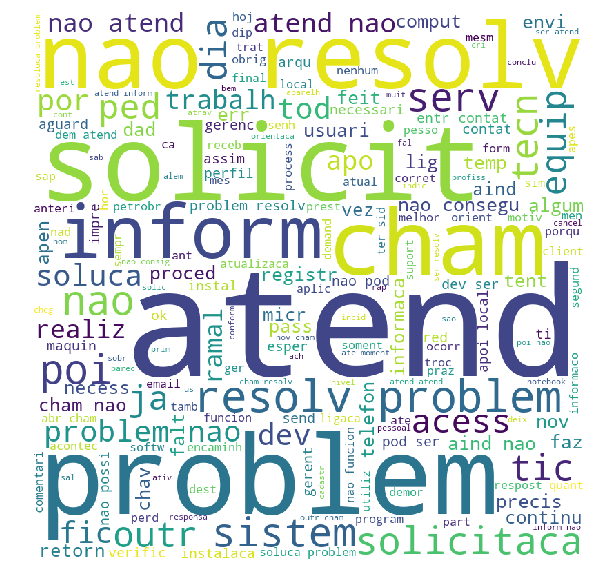

In [27]:
reclamacoes.coment = reclamacoes.coment_stem
nuvem_palavras(reclamacoes)

Com os radicais, novamente potencializamos algumas ocorrências, principalmente, **problem**.

Após as análises e preparação dos dados, começamos a treinar nossos modelos Naive Bayes e SVM.

In [59]:
def nb_model(X, Y):

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                        Y, 
                                                                        test_size=0.3)

    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, 
                                                                      y_train, 
                                                                      test_size=0.2)
    
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)
    y_val = Encoder.fit_transform(y_val)

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(X)
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)
    Val_X_Tfidf = Tfidf_vect.transform(X_val)

    Naive = naive_bayes.MultinomialNB()
    Naive.fit(Train_X_Tfidf, y_train)

    predictions_NB_test = Naive.predict(Test_X_Tfidf)
    result_test = accuracy_score(predictions_NB_test, y_test)*100

    predictions_NB_val = Naive.predict(Val_X_Tfidf)
    result_val = accuracy_score(predictions_NB_val, y_val)*100
    
    return result_test, result_val

In [60]:
res_test, res_val = nb_model(dataset["coment_stem"],dataset["manifest_atendimento"])
print("Acuracia NB Teste:", res_test)
print("Acuracia NB Validação:", res_val)

Acuracia NB Teste: 92.43618027103687
Acuracia NB Validação: 92.19989869998312


In [61]:
def svm_model(X, Y):

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                        Y, 
                                                                        test_size=0.3)

    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, 
                                                                      y_train, 
                                                                      test_size=0.2)
    
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)
    y_val = Encoder.fit_transform(y_val)

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(X)
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)
    Val_X_Tfidf = Tfidf_vect.transform(X_val)

    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Train_X_Tfidf, y_train)

    predictions_SVM_test = SVM.predict(Test_X_Tfidf)
    result_test = accuracy_score(predictions_SVM_test, y_test)*100

    predictions_SVM_val = SVM.predict(Val_X_Tfidf)
    result_val = accuracy_score(predictions_SVM_val, y_val)*100
    
    return result_test, result_val

In [62]:
res_test, res_val = svm_model(dataset["coment_stem"],dataset["manifest_atendimento"])
print("Acuracia SVM Teste:", res_test)
print("Acuracia SVM Validação:", res_val)

Acuracia SVM Teste: 93.35014182161991
Acuracia SVM Validação: 93.14536552422759


Comparando as acurácias dos modelos Naive Bayes e SVM aplicados aos comentários com todos os tratamentos de remoção de caracrteres especiais, remoção de stopwords e aplicação de stemming com os comentários utilizados puros, ou seja, sem nenhum tratamento, percebemos que os resultados ficaram muito próximos.

In [63]:
res_test, res_val = nb_model(dataset["coment_puro"],dataset["manifest_atendimento"])
print("Acuracia NB Teste:", res_test)
print("Acuracia NB Validação:", res_val)

Acuracia NB Teste: 92.60163882760794
Acuracia NB Validação: 92.36873206145533


In [64]:
res_test, res_val = svm_model(dataset["coment_puro"],dataset["manifest_atendimento"])
print("Acuracia SVM Teste:", res_test)
print("Acuracia SVM Validação:", res_val)

Acuracia SVM Teste: 93.61802710368737
Acuracia SVM Validação: 93.21289886881647
